# 2. Load and train model

### 1. Import dependencies¶

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image

In [3]:
import datetime
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-03 07:26:02.685648


In [4]:
torch.__version__

'1.4.0'

### 2. Create PyTorch data generators¶

In [5]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

In [6]:
# define dataloader parameters
batch_size = 64
num_workers_train = 2
num_workers_validation = 4
num_workers_test = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
normalize = transforms.Normalize(mean=[0.5],
                                 std=[0.5])
data_transform = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(1),
        transforms.RandomAffine(0, translate=(0.2, 0.2)),
        transforms.RandomAffine(0, shear=20),
        transforms.RandomAffine(0, scale=(0.8, 1.2)),
#        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize
])

data_transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        normalize
])

image_datasets = {
    'train':
        datasets.ImageFolder('./source_data_2/train/', data_transform),
    'validation': 
        datasets.ImageFolder('./source_data_2/valid/', data_transform),
    'test': 
        datasets.ImageFolder('./source_data_2/test/', data_transform_test)
}

a = torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True, num_workers=num_workers_train)
b = torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_validation)
c = torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_test)

dataloaders = {
    'train':
    WrappedDataLoader(a, to_device),
    'validation':
    WrappedDataLoader(b, to_device),
    'test':
    WrappedDataLoader(c, to_device)
}

In [7]:
#calculate sample weights
train_size = 43 * 15000

class_sample_count = pd.read_csv('sign_count.csv')['count'].to_numpy()
class_weights = 1 / class_sample_count
class_id=0
sample_weights = list()
for class_weight in class_weights:
    sample_weights += ([class_weight] * class_sample_count[class_id])
    class_id += 1 

#replace train dataset
samp = sampler.WeightedRandomSampler(sample_weights, train_size)
a = torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                num_workers=num_workers_train, sampler=samp)
dataloaders['train'] = WrappedDataLoader(a, to_device)

iterations: 10079
images: 645000


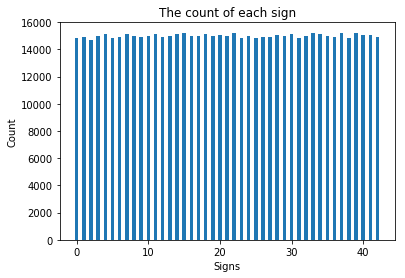

In [8]:
#verify weights
def vis_weighted_sign_count():
    balanced_y_train = torch.LongTensor([]).to(device)
    i = 0
    progress_bar_weights = tqdm(range(int(train_size/batch_size)), desc='Checking weights: ')
    with torch.no_grad():
        for _, y in dataloaders['train']:
            i += 1
            balanced_y_train = torch.cat((balanced_y_train, y))
            progress_bar_weights.update()

    print('iterations: {}'.format(i))
    print('images: {}'.format(len(balanced_y_train)))

    fig, ax = plt.subplots()
    ax.bar(range(43), np.bincount(balanced_y_train.cpu().numpy()), 0.5)
    ax.set_xlabel('Signs')
    ax.set_ylabel('Count')
    ax.set_title('The count of each sign')
    plt.show()

#vis_weighted_sign_count()

### 3. Create the network

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
#model = models.resnet50(pretrained=True).to(device)
#    
#for param in model.parameters():
#    param.requires_grad = False   
    
#model.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 43)).to(device)

In [11]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [12]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        #input_chan = 1 if gray else 3
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x
model = BaselineNet(gray=True).to(device)
torch.save(model.state_dict(), 'model.start')

In [13]:
model.load_state_dict(torch.load('model.start'))

<All keys matched successfully>

In [14]:
#model = models.resnet18(pretrained=True).to(device)

In [15]:
#for param in model.parameters():
#    param.requires_grad = False   
#model.fc = nn.Linear(512, 43).to(device)

In [16]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters())

In [17]:
print(model)

BaselineNet(
  (stn): Stn(
    (loc_net): Sequential(
      (0): Conv2d(1, 50, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ELU(alpha=1.0)
      (3): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ELU(alpha=1.0)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=1600, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con

### 4. Train the model¶

In [18]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            datasize = len(image_datasets[phase])
            if phase == 'train':
                datasize = train_size
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            train_loss = 0.0
            i = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                                

                epoch_loss = running_loss / datasize
                epoch_acc = running_corrects.float() / datasize
                train_loss += loss.item()
                if i % 500 == 499:
                    print('phase: {}, batch: {}, loss: {:.4f}, train_loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                        i+1,
                                                                        epoch_loss.item(),
                                                                        train_loss / 500,
                                                                        epoch_acc.item()))
                    train_loss = 0.0
                i += 1


            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [19]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)


In [20]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)



In [21]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [22]:
%%time
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_trained = train_model(model, criterion, optimizer, num_epochs=1)
evaluate(model, criterion, dataloaders['test'])

Epoch 1/1
----------


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


phase: train, batch: 500, loss: 0.1923, train_loss: 3.8767, acc: 0.0017
phase: train, batch: 1000, loss: 0.3846, train_loss: 3.8751, acc: 0.0028
phase: train, batch: 1500, loss: 0.5749, train_loss: 3.8358, acc: 0.0040
phase: train, batch: 2000, loss: 0.7644, train_loss: 3.8207, acc: 0.0051
phase: train, batch: 2500, loss: 0.9535, train_loss: 3.8105, acc: 0.0063
phase: train, batch: 3000, loss: 1.1422, train_loss: 3.8035, acc: 0.0075
phase: train, batch: 3500, loss: 1.3307, train_loss: 3.8002, acc: 0.0086
phase: train, batch: 4000, loss: 1.5189, train_loss: 3.7929, acc: 0.0098
phase: train, batch: 4500, loss: 1.7067, train_loss: 3.7844, acc: 0.0110
phase: train, batch: 5000, loss: 1.8942, train_loss: 3.7805, acc: 0.0122
phase: train, batch: 5500, loss: 2.0817, train_loss: 3.7792, acc: 0.0134
phase: train, batch: 6000, loss: 2.2690, train_loss: 3.7747, acc: 0.0146
phase: train, batch: 6500, loss: 2.4561, train_loss: 3.7716, acc: 0.0157
phase: train, batch: 7000, loss: 2.6432, train_loss:

In [23]:
torch.save(model.state_dict(), 'model.pre-trained_1')

In [37]:
#model.load_state_dict(torch.load('model.pre-trained_1'))

<All keys matched successfully>

In [25]:
%%time
#decrease lr and train more 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model_trained = train_model(model, criterion, optimizer, num_epochs=3)
evaluate(model, criterion, dataloaders['test'])

Epoch 1/3
----------


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


phase: train, batch: 500, loss: 0.1867, train_loss: 3.7632, acc: 0.0012
phase: train, batch: 1000, loss: 0.3733, train_loss: 3.7618, acc: 0.0024
phase: train, batch: 1500, loss: 0.5600, train_loss: 3.7627, acc: 0.0036
phase: train, batch: 2000, loss: 0.7467, train_loss: 3.7627, acc: 0.0048
phase: train, batch: 2500, loss: 0.9334, train_loss: 3.7625, acc: 0.0059
phase: train, batch: 3000, loss: 1.1200, train_loss: 3.7623, acc: 0.0071
phase: train, batch: 3500, loss: 1.3067, train_loss: 3.7623, acc: 0.0082
phase: train, batch: 4000, loss: 1.4933, train_loss: 3.7621, acc: 0.0093
phase: train, batch: 4500, loss: 1.6800, train_loss: 3.7619, acc: 0.0105
phase: train, batch: 5000, loss: 1.8666, train_loss: 3.7621, acc: 0.0117
phase: train, batch: 5500, loss: 2.0532, train_loss: 3.7618, acc: 0.0128
phase: train, batch: 6000, loss: 2.2399, train_loss: 3.7620, acc: 0.0140
phase: train, batch: 6500, loss: 2.4265, train_loss: 3.7620, acc: 0.0151
phase: train, batch: 7000, loss: 2.6132, train_loss:

KeyboardInterrupt: 

In [26]:
torch.save(model.state_dict(), 'model.pre-trained_2')

In [38]:
%%time
evaluate(model, criterion, dataloaders['test'])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Test loss: 3.759593	Test accruacy: 0.475%
CPU times: user 1.53 s, sys: 263 ms, total: 1.79 s
Wall time: 2.44 s


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


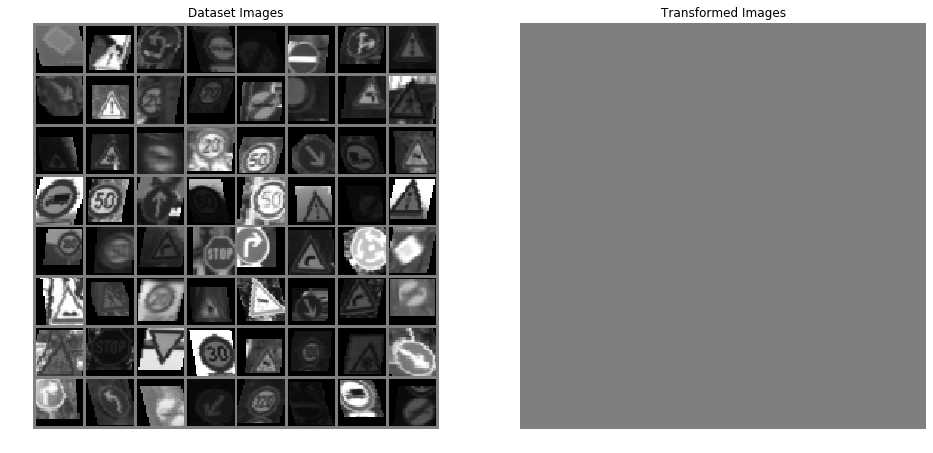

In [39]:

def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        data = next(iter(dataloaders['train']))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()

In [29]:
%%time
#unfreeze the whole model and train for two more epochs
#for param in model.parameters():
#    param.requires_grad = True 
#model_trained = train_model(model_trained, criterion, optimizer, num_epochs=2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


### 5. Save and load the model¶

In [30]:
#torch.save(model_trained.state_dict(), 'weights.h5')

In [31]:
#model = models.resnet50(pretrained=False).to(device)
#model.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 2)).to(device)
#model.load_state_dict(torch.load('weights.h5'))

In [32]:
#model = models.resnet18(pretrained=False).to(device)
#model.fc = nn.Linear(512, 43).to(device)
#model.load_state_dict(torch.load('weights.h5'))

### 6. Make predictions on sample test images¶

In [44]:
validation_img_paths = ["./source_data_2/test/00/00243.ppm",
                        "./source_data_2/test/01/00001.ppm",
                        "./source_data_2/test/02/00034.ppm"]
#validation_img_paths = ["./source_data_2/train/35/hflip_hflip_00039_00010.ppm",
#                        "./source_data_2/train/35/hflip_hflip_00039_00021.ppm",
#                        "./source_data_2/train/35/hflip_hflip_00039_00029.ppm"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_classes = [0, 1, 2]
#validation_classes = [35, 35, 35]

In [45]:
validation_batch = torch.stack([data_transform(img).to(device)
                                for img in img_list])

In [46]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


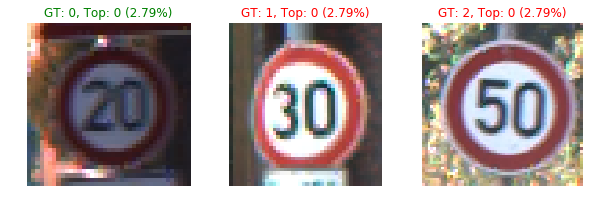

In [47]:
#pred_probs=np.random.random_sample((3, 43))

fig, axs = plt.subplots(1, len(img_list), figsize=(10, 3))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    maxConfidenceValue = np.amax(pred_probs[i,:])
    maxConfidenceClass = np.where(pred_probs[i,:] == maxConfidenceValue)[0][0]
    color = 'green'
    if maxConfidenceClass != validation_classes[i]:
        color = 'red'
    ax.set_title("GT: {}, Top: {} ({:.2f}%)".format(validation_classes[i], maxConfidenceClass, maxConfidenceValue*100), color=color)
    ax.imshow(img)

In [ ]:
currentDT = datetime.datetime.now()
print (str(currentDT))